## Pizza vs IceCream Binary Classification with EfficientNet 

[Korean](02_pizza_vs_icecream.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Image Classification 모델을 학습하는 과정을 다루고 있습니다.

## Process
1. Scoping : 문제정의
2. Data : 데이터 수집, 분석
3. Modeling : 적합한 모델 선정
4. Training : 데이터 학습
5. Analysis : 모델 분석 및 평가

## 1. Scoping (문제 정의)

- Garbage Image가 주어졌을 때 해당 Image가 어떤 Garbage인지를 분류합니다.
  - Input : Image File
  - Output : Garbage Class

## 2. Data (데이터 수집 및 분석)
- 데이터 수집은 최초 한번으로 끝나는 것이 아닌 이후 모델링, 학습, 평가 기간동안 계속해서 염두해야 합니다.
- 데이터 분석은 정량적, 정성적으로 살펴보아야 합니다.

### 2.1. Summary

- Dataset Download : https://www.kaggle.com/datasets/hemendrasr/pizza-vs-ice-cream
- Dataset Tree
    ```
        pizza_vs_icecream
        ├─train
        │  ├─pizza     : 327 files
        │  └─icecream  : 391 files
        ├─train
        │  ├─pizza     : 327 files
        │  └─icecream  : 391 files
        └─train
           ├─pizza     : 327 files
           └─icecream  : 391 files
    ```
- Dataset Configuration
    - The number of images : 2,154 files
    - The number of classes : 2
        - pizza, icecream
    - Average number of images per class : 1,077 files

### 2.2. Data Analysis

실제 데이터에 어떤 이미지가 있는지 살펴봅니다.

(Optional) gdrive에 있는 데이터를 mount 할때 아래와 같이 mount 후 데이터 경로를 지정해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_main = "/content/gdrive/MyDrive/dataset/pizza_vs_icecream/"

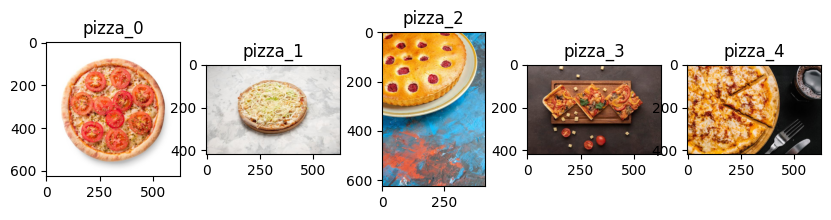

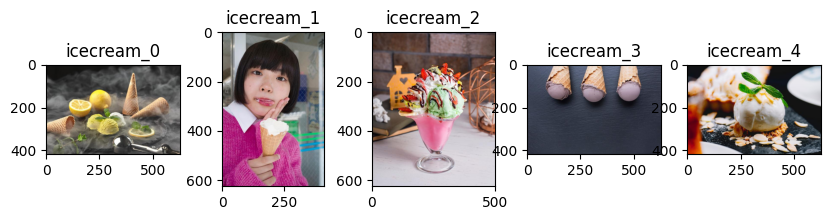

In [10]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

dir_main = "../../../data/pizza_vs_icecream/"
classes = ['pizza', 'icecream']
source = "train"
image_paths = glob(os.path.join(dir_main, source, "*/*.jpg"))

cls_image_paths = {}
n_show = 5
for cls in classes:
    cls_image_paths[cls] = [image_path for image_path in image_paths if cls == image_path.split("/")[-2]][:n_show]

for cls in classes:
    fig, axes = plt.subplots(nrows=1, ncols=n_show, figsize=(10,2))
    for idx, image_path in enumerate(cls_image_paths[cls]):
        img = Image.open(image_path)
        axes[idx].set_title(f"{cls}_{idx}")
        axes[idx].imshow(img)

### 2.3. Preprocessing dataset for train, validation and test

#### Preprare the dataset

In [11]:
import os
import numpy as np
from glob import glob
np.random.seed(724)

dir_main = "../../../data/pizza_vs_icecream/"
classes = ['pizza', 'icecream']

dir_train = os.path.join(dir_main, 'train')
x_train = glob(f"{dir_train}/*/*.jpg")
y_train = np.array([x.split("/")[-2] for x in x_train])

dir_test = os.path.join(dir_main, 'test')
x_test = glob(f"{dir_train}/*/*.jpg")
y_test = np.array([x.split("/")[-2] for x in x_test])

dir_val = os.path.join(dir_main, 'valid')
x_val = glob(f"{dir_train}/*/*.jpg")
y_val = np.array([x.split("/")[-2] for x in x_val])

In [12]:
def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y in ys:
        if y not in cls_cnt.keys():
            cls_cnt[y]=0
        cls_cnt[y]+=1
    if cls is None:
        return cls_cnt
    return cls_cnt[cls]

print(f"Class\t\tTrain\tVal\tTest\n")
for cls in classes:
    print(f"{cls:10}\t{get_numbers(y_train, cls)}\t{get_numbers(y_val, cls)}\t{get_numbers(y_test, cls)}")

Class		Train	Val	Test

pizza     	327	327	327
icecream  	391	391	391


### 2.4. Create DataLoader

In [13]:
import torch
from torch.utils.data import Dataset
from glob import glob

class PizzaIcecreamDataset(Dataset): 
    def __init__(self, dir_dataset, tr):
        self.dir_dataset = os.path.abspath(dir_dataset)
        self.filelist = glob(self.dir_dataset + '/*/*.jpg')
        assert len(self.filelist)!=0, f"{self.dir_dataset + '/*/*.jpg'} is empty"
        self.classes = ['pizza', 'icecream']
        self.tr = tr

    def get_image(self, filename):
        img = Image.open(filename)
        img = self.tr(img)
        return img

    def get_label(self, filename):
        label = np.array([0] * len(self.classes))
        cls = filename.split('/')[-2]
        label[self.classes.index(cls)] = 1
        return torch.from_numpy(label).type(torch.FloatTensor)


    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label

    def __len__(self): 
        return len(self.filelist)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [16]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# print(model.default_cfg['mean']) # 'mean': (0.485, 0.456, 0.406)
# print(model.default_cfg['std']) # 'std': (0.229, 0.224, 0.225)
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_tr = T.Compose([
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

test_tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])
train_ds = PizzaIcecreamDataset(os.path.join(dir_main, "train"), train_tr)
val_ds = PizzaIcecreamDataset(os.path.join(dir_main, "valid"), test_tr)
test_ds = PizzaIcecreamDataset(os.path.join(dir_main, "test"), test_tr)

train_dl = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=64)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### 3. Modeling

#### 3.1. Select Model - EfficientNet

EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks ([Paper](https://arxiv.org/abs/1905.11946)) 이란?

2020년에 나온 Architecture로 Google에서 Neural Architecture 최적화 기법 중 하나인 NAS(Neural Architecture Search)를 찾은 가성비 좋은 Scalable Architecture입니다.
Scalable한 이유는 NAS의 파라미터와 관련이 있습니다. 모델의 크기는 크게 아래 세가지 파라미터로 볼 수 있습니다.

<center><img src = "https://drive.google.com/uc?id=1dvD_KIiNVkj6ntF5QNo_LqfkK_xYLjQ4"  height = 300> </center>
AutoML: EfficientNet은 AutoML 기술을 활용하여 최적의 모델 구조를 찾아냅니다. 이를 통해 사람의 경험과 직관에 의존하지 않고, 자동적으로 최적의 모델을 생성할 수 있습니다.
1. channel width를 늘리는 것 : filter 수
2. network의 depth를 깊게 만드는 것 : layer 수
3. input image의 해상도를 올리는 것 : resolution 

<center><img src = "https://drive.google.com/uc?id=1DYrvKQN4Vlq_Pt6RjYKXQMWDIwgPtsRH" height = 400></center>
Compound Scaling: EfficientNet은 Width, Depth, Resolution의 3가지 요소를 조절하여 모델의 성능과 효율성을 극대화합니다. 이를 Compound Scaling이라고 부르며, 이전에는 이 3가지 요소를 각각 조절하여 모델을 개발했지만, EfficientNet은 이를 종합적으로 고려하여 최적의 구조를 찾아냅니다.
ImageNet에서 기존 ConvNet보다 8.4배 작으면서 6.1배 빠르고 더 높은 정확도를 갖는다.


<center><img src = "https://drive.google.com/uc?id=19Gq1NPLK333XQbRyEx9qlsNYS3k-xH8t" height = 300></center>
Efficient Blocks: EfficientNet은 기존의 ResNet과는 달리 Residual Connection 대신 Inverted Residual Block이라는 구조를 사용합니다. 이 구조는 모바일 기기에서도 빠르고 효율적인 실행이 가능하며, Depthwise Separable Convolution과 Swish Activation Function 등의 기술을 적용하여 높은 성능을 보입니다. 여기서 MBConv은 Inverted Residual Block + SE Block 의 조합이입니다.


#### 3.2. Package Installation

아래 package를 설치 합니다.
- [timm](https://github.com/rwightman/pytorch-image-models), [opencv](https://github.com/opencv/opencv-python), [sklearn](https://scikit-learn.org/stable/index.html)

```
    # install dependancy
    pip install timm
    pip install opencv-python
    pip install scikit-learn
    # pip install -r requirements.txt
```

#### 3.3. Loading Model

Timm에는 기존에 학습된 여러 pretrained 모델을 제공합니다.

In [17]:
import timm

print(f"The number of pretrained models : {len(timm.list_models('*', pretrained=True))}")
timm.list_models('efficientnet*', pretrained=True)

The number of pretrained models : 770


['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t']

In [18]:
model = timm.create_model('efficientnet_b0', pretrained=True)
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'architecture': 'efficientnet_b0'}

In [25]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(classes), global_pool='avg')
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 6])

In [28]:
import timm
from torch import nn
import torch.nn.functional as F

class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(classes), global_pool='avg')
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = EfficientNet()
# to_device(model, device)

In [29]:
import pickle
import os

class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        self.history = history
        self.save_path = save_path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    def accuracy(self, outputs, labels):
        pred = torch.max(outputs, dim=1)[1]
        gt = torch.max(labels, dim=1)[1]
        return torch.tensor(torch.sum(pred == gt).item() / len(pred))

    @torch.no_grad()
    def validation(self, batch):
        images, labels = batch 
        out = model(images)
        acc = self.accuracy(out, labels)
        loss = F.binary_cross_entropy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @torch.no_grad()
    def evaluation(self, model, data_loader):
        model.eval()
        outputs = [self.validation(batch) for batch in data_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    def logging(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        self.history.append(result)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

train_helper = TrainHelper()

In [30]:
train_helper.evaluation(model, val_dl)

{'val_loss': 0.56136, 'val_acc': 0.73828}

## 4.Training

In [31]:
from tqdm import tqdm

epochs = 5
optimizer = torch.optim.Adam(model.parameters(), 5.5e-5)
val_acc_best = 0
save_model_path = "./ckpt/"
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    for batch in tqdm(train_dl):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.binary_cross_entropy(outputs, targets)

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    result = train_helper.evaluation(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()

    # Save the best model
    if result['val_acc'] >= val_acc_best:
        val_acc_best = result['val_acc']
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)

100%|██████████| 12/12 [01:15<00:00,  6.27s/it]


Saved PyTorch Model State to ./ckpt/best_ep_0_0.85156.pt
Epoch 0: train_loss: 0.5771, val_loss: 0.4797, val_acc: 0.8516


100%|██████████| 12/12 [01:14<00:00,  6.20s/it]


Saved PyTorch Model State to ./ckpt/best_ep_1_0.93359.pt
Epoch 1: train_loss: 0.4686, val_loss: 0.4224, val_acc: 0.9336


100%|██████████| 12/12 [01:16<00:00,  6.37s/it]


Saved PyTorch Model State to ./ckpt/best_ep_2_0.94141.pt
Epoch 2: train_loss: 0.3953, val_loss: 0.3933, val_acc: 0.9414


100%|██████████| 12/12 [01:20<00:00,  6.69s/it]


Saved PyTorch Model State to ./ckpt/best_ep_3_0.94531.pt
Epoch 3: train_loss: 0.4070, val_loss: 0.3751, val_acc: 0.9453


100%|██████████| 12/12 [01:04<00:00,  5.37s/it]


Saved PyTorch Model State to ./ckpt/best_ep_4_0.94531.pt
Epoch 4: train_loss: 0.3880, val_loss: 0.3647, val_acc: 0.9453


##### Train & Validation Losses

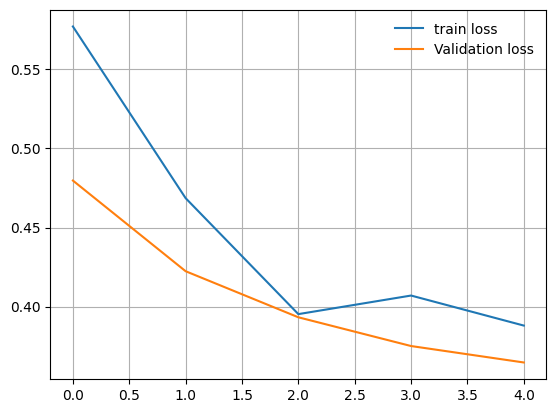

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

##### Accuracy

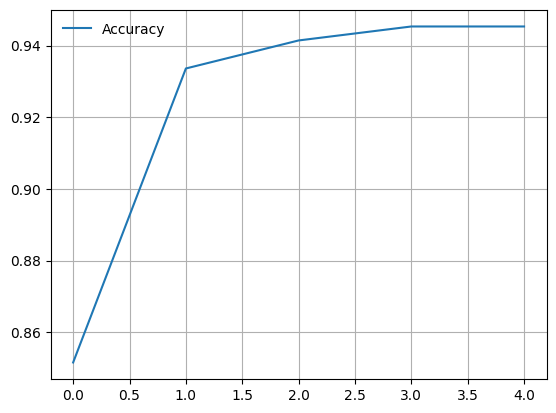

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc = [history['val_acc'] for history in train_helper.history]
plt.plot(val_acc, label='Accuracy')
plt.grid()
plt.legend(frameon=False)

## 5. Analysis

##### Confusion Matrix

100%|██████████| 2/2 [00:05<00:00,  2.56s/it]

Classes : ['pizza', 'icecream']
Performance 
              precision    recall  f1-score   support

           0      0.978     0.957     0.968        47
           1      0.967     0.983     0.975        59

    accuracy                          0.972       106
   macro avg      0.972     0.970     0.971       106
weighted avg      0.972     0.972     0.972       106



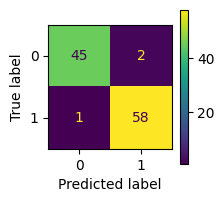

In [34]:
from sklearn import metrics
import matplotlib.pyplot as plt

model.eval()

y_pred = []
y_true = []
for batch in tqdm(test_dl):
    inputs, targets = batch
    outputs = model(inputs)
    y_pred.extend(torch.max(outputs, dim=1)[1].numpy())
    y_true.extend(torch.max(targets, dim=1)[1].numpy())

performance = metrics.classification_report(y_true, y_pred, digits=3)
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

classes = test_ds.classes
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(len(classes))))
print(f"Classes : {classes}")
print(f"Performance \n{performance}")

disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(len(classes))
fig.set_figheight(len(classes)) 
plt.savefig("confusion_matrix.jpg")
plt.show()

#### Load Trained Model

In [20]:
import torch

model=EfficientNet()
model.load_state_dict(torch.load("./ckpt/best_ep_4_0.94531.pt", map_location='cpu'))

<All keys matched successfully>

In [ ]:
# Recovery of normalized image dataset for visualization
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

#### False Positive Cases

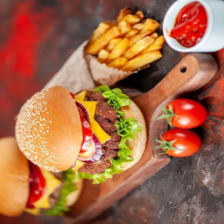

Prediction   : icecream (0.5644)
Ground Truth : pizza


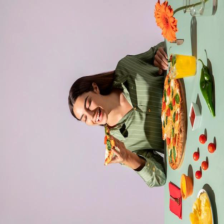

Prediction   : icecream (0.0766)
Ground Truth : pizza


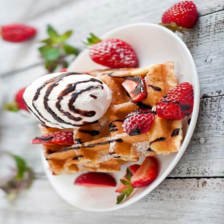

Prediction   : pizza (0.9787)
Ground Truth : icecream


In [35]:
from IPython.display import display
from PIL import Image
FP = 3
for data in test_dl:
    if FP==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if FP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p!=g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            FP -= 1


#### True Positive Cases (Low confidence, Edge case)

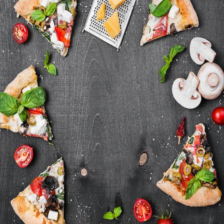

Prediction   : pizza (0.2986)
Ground Truth : pizza


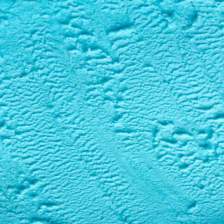

Prediction   : icecream (0.4103)
Ground Truth : icecream


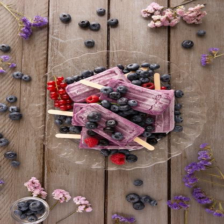

Prediction   : icecream (0.3942)
Ground Truth : icecream


In [36]:
TP = 3
for data in test_dl:
    if TP <= 0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p==g and conf < 0.5:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            TP -= 1